In [ ]:
import os
from dotenv import load_dotenv
import pickle
import requests
import pandas as pd
from datetime import datetime, timedelta



from langchain.tools import tool
from langchain_groq import ChatGroq

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.errors import GraphRecursionError
from bs4 import BeautifulSoup

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [4]:
with open('../data/country_specific_graphs/graph_combined_IND.pkl', 'rb') as f:
    G = pickle.load(f)

In [5]:
@tool("get_node_edge_connections")
def get_node_edge_connections_tool(actor: str, recipient: str, date: str):
    """
    Returns up to 10 edges where the actor or recipient is involved before the given date.
    Each result includes source, relation type, target, and timestamp.
    """
    ref_date = pd.to_datetime(date)
    relevant_edges = []

    for u, v, data in G.edges(data=True):
        if actor in [u, v] or recipient in [u, v]:
            ts = pd.to_datetime(G.nodes[u].get("event_date") or G.nodes[v].get("event_date"), errors="coerce")
            if pd.notna(ts) and ts < ref_date:
                relevant_edges.append((u, data.get("relation", "related_to"), v, ts.strftime("%Y-%m-%d")))

    return relevant_edges[:10]


@tool("print_node_attributes")
def print_node_attributes_tool(actor: str, recipient: str, date: str):
    """
    Returns metadata for up to 5 event nodes where both actor and recipient are connected.
    Includes event date and a truncated event text field.
    """
    input_date_dt = pd.to_datetime(date)
    matching_events = []

    for node in G.nodes:
        event_meta = G.nodes[node]
        event_date = pd.to_datetime(event_meta.get("event_date"), errors="coerce")

        if pd.notna(event_date):
            neighbors = list(G.neighbors(node))
            if actor in neighbors and recipient in neighbors:
                time_diff = abs((event_date - input_date_dt).days)
                matching_events.append((node, time_diff, event_meta))

    matching_events.sort(key=lambda x: x[1])
    top_events = matching_events[:5]

    return {
        event[0]: {
            "event_date": str(event[2].get("event_date")),
            "event_text": (event[2].get("event_text") or "")[:300] + "..."
            if event[2].get("event_text") and len(event[2].get("event_text")) > 300 else event[2].get("event_text", "No text available")
        }
        for event in top_events
    }

@tool("calculate_event_type_frequency")
def calculate_event_type_frequency_tool(actor: str, recipient: str, date: str):
    """
    Counts and returns up to 10 most frequent event types involving the actor or recipient before the given date.
    """
    ref_date = pd.to_datetime(date)
    event_counts = {}

    for u, v, data in G.edges(data=True):
        if actor in [u, v] or recipient in [u, v]:
            ts = pd.to_datetime(G.nodes[u].get("event_date") or G.nodes[v].get("event_date"), errors="coerce")
            if pd.notna(ts) and ts < ref_date:
                etype = G.nodes[u].get("event_type") or G.nodes[v].get("event_type")
                if etype:
                    event_counts[etype] = event_counts.get(etype, 0) + 1
    return dict(sorted(event_counts.items(), key=lambda x: x[1], reverse=True)[:10])


@tool("summarize_actor_recipient_history")
def summarize_actor_recipient_history(actor: str, recipient: str):
    """
    Returns a list of up to 10 events connecting the actor and recipient.
    Each includes event ID, date, and a truncated event text for quick summarization.
    """
    summaries = []

    for node in G.nodes:
        meta = G.nodes[node]
        event_date = pd.to_datetime(meta.get("event_date"), errors="coerce")
        neighbors = list(G.neighbors(node))

        if actor in neighbors and recipient in neighbors:
            summaries.append({
                "event_id": node,
                "event_date": str(event_date.date()) if pd.notna(event_date) else "N/A",
                "event_text": (meta.get("event_text") or "")[:300] + "..."
                if meta.get("event_text") and len(meta.get("event_text")) > 300 else meta.get("event_text", "No summary available")
            })

    summaries.sort(key=lambda x: x["event_date"])
    return summaries[:10]


In [6]:
@tool("search-news")
def search_and_extract_news_tool(actor: str, recipient: str, date: str):
    """
    Searches for news articles about the actor and recipient from the week before the given date.
    """
    # Build the query
    if actor and recipient:
        query = f"{actor} AND {recipient}"
    elif actor:
        query = actor
    elif recipient:
        query = recipient
    else:
        query = ""

    # Calculate date range
    end_date = datetime.strptime(date, "%Y-%m-%d")
    start_date = end_date - timedelta(days=7)
    api_key = os.getenv("NEWS_API_KEY")
    url = (
        f"https://api.thenewsapi.com/v1/news/all"
        f"?api_token={api_key}"
        f"&search={query}"
        f"&language=en"
        f"&limit=10"
        f"&published_after={start_date.strftime('%Y-%m-%d')}"
        f"&published_before={end_date.strftime('%Y-%m-%d')}"
    )

    response = requests.get(url)
    if response.status_code == 200:
        articles = response.json().get('data', [])
        results = []
        for article in articles:
            article_url = article.get("url")
            if not article_url:
                continue
            content = scrape_content(article_url)
            if content:
                results.append({
                    "title": article.get("title"),
                    "content": content[:500],
                    "url": article_url,
                    "published_at": article.get("published_at")
                })
        return {"articles": results} if results else {"message": "No articles found for the specified criteria."}
    else:
        return {"error": f"Error fetching news articles: {response.status_code}"}


def scrape_content(url):
    """
    Scrapes and cleans article content from the given URL.
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        content = ' '.join(p.get_text(strip=True) for p in paragraphs)
        content = ' '.join(content.split())
        return content
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch the URL {url}: {e}")
        return None


In [7]:
tools = [
    get_node_edge_connections_tool,
    print_node_attributes_tool,
    calculate_event_type_frequency_tool,
    summarize_actor_recipient_history,
    search_and_extract_news_tool
]


tool_node = ToolNode(tools)

In [8]:
model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.1).bind_tools(tools)

In [9]:
system_prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop, you output an Answer providing the top 3 predictions, but ONLY after sufficient investigation using multiple tools.

Use:
- Thought → Explain your reasoning process, plan next steps, or analyze observations. Intermediate thoughts should NOT contain the final "Answer:" tag.
- Action → Invoke ONE tool per step (return PAUSE after).
- Observation → Reflect on the output of the tool.
- Answer → Conclude with the final top 3 predictions ONLY in the final step.

---

Task:
You will be given an actor, recipient, and a date.
Your goal is to predict the **top 3 most likely** event types between the given actor and recipient on the given date, **ordered from most to least likely**, based on evidence gathered from MULTIPLE tools.

YOUR FINAL ANSWER MUST BE an **ordered list of three distinct event types** from the following options:
CONCEDE, COOPERATE, ASSAULT, THREATEN, CONSULT, RETREAT, PROTEST, COERCE, AID, MOBILIZE, REQUEST, SANCTION, ACCUSE

---

Available Tools:

1.  **get_node_edge_connections**
    Use this to find recent connections involving the actor or recipient before the given date.
    Use early to build context of prior activity.
    Format:
    `get_node_edge_connections: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

2.  **print_node_attributes**
    Use this to retrieve rich metadata (e.g., event text, date) from specific events involving both the actor and recipient.
    Use this to understand interaction context, potentially after finding relevant connections.
    Format:
    `print_node_attributes: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}` (Note: You might need specific event IDs from other tools for pinpoint accuracy, adapt as needed based on tool capabilities)

3.  **calculate_event_type_frequency**
    Use this to check which event types occurred most frequently in the past between the actor and recipient.
    Frequency is helpful context but should NOT be your only deciding factor, especially for ranking.
    Format:
    `calculate_event_type_frequency: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

4.  **summarize_actor_recipient_history**
    Use this to get a chronological list of past events connecting the actor and recipient.
    Best for trend spotting or escalation/de-escalation patterns.
    Format:
    `summarize_actor_recipient_history: {{"actor": "A", "recipient": "B"}}`

5.  **search_news**
    Use this to search real news around the actor and recipient near the given date.
    Use if event_text or historical data is missing, unclear, or needs external validation.
    Format:
    `search_news: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

---

Instructions:

- Start by exploring the context (e.g., history, recent connections, frequency, news).
- **Use the tools in a logical order** to build a comprehensive understanding of the actor-recipient relationship.
- **Crucially, do NOT conclude with a final 'Answer:' after using only one tool.** Your goal is comprehensive analysis to support multiple predictions.
- **Aim to use at least two *different* tools** to corroborate findings or gain broader context before proceeding to the final reasoning step. Use outputs from one tool to guide the selection of the next.
- If data is sparse even after using multiple tools, acknowledge this in your reasoning, use news search as a fallback if appropriate, and make the best predictions possible.
- Intermediate `Thought:` steps are for planning and analysis, not for final answers. Only the final output block should contain the `Answer:` tag.
- Your final reasoning must justify the choice and *ranking* of the top 3 event types.

---

Final Reasoning Format (Use this structure ONLY when ready to provide the final answer after using multiple tools):

Thought: I have gathered sufficient evidence from multiple tools (<<List Tools Used>>) and synthesized the findings to make well-informed predictions for the top 3 event types.
Action: I will now consolidate the analysis and provide the final ranked answer.
Observation Summary:
- <<Tool 1 Name>>: <<Brief summary of key findings/data>>
- <<Tool 2 Name>>: <<Brief summary of key findings/data>>
- (Add more tools as used)
Thought: Based on the synthesis of information from these tools (e.g., trends from history, specific details from metadata/news, common patterns from frequency), the **top 3 most likely event types, in descending order of likelihood,** are <<EVENT TYPE 1>>, <<EVENT TYPE 2>>, and <<EVENT TYPE 3>> because <<Explain reasoning for the choices and their ranking. Justify why #1 is most likely, why #2 is next, etc., referencing specific evidence from the Observation Summary. Acknowledge if ranking between certain types is close or based on subtle distinctions.>>.
Answer: <<EVENT TYPE 1>>, <<EVENT TYPE 2>>, <<EVENT TYPE 3>>

Now it's your turn:
""".strip()

system_message = SystemMessage(content=system_prompt)

In [10]:
def should_continue(state: MessagesState) -> str:
    """
    Determines whether to continue looping or stop
    """
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState) -> MessagesState:
    """
    Calls the model with the current state, increments the iteration counter,
    and returns the updated state.
    """
    try:
        messages = state["messages"]
        response = model.invoke([system_message] + messages)
        # Update the iteration counter.
        current_iteration = state.get("iteration", 0)
        state["iteration"] = current_iteration + 1
        state["messages"] = response
        return state
    except GraphRecursionError:
        print("Recursion error occurred. Please check the graph structure.")
        return state

# Build your workflow using the updated functions.
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()


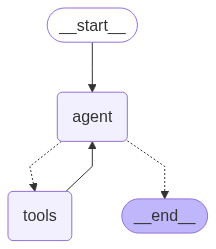

In [11]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
messages = [
    HumanMessage(content="What is the most likely relation between 'Delhi High Court' and 'Arvind Kejriwal' on 2024-06-29, Choose from: ACCUSE, THREATEN, COERCE, SANCTION, REQUEST, ASSAULT, RETREAT, CONCEDE, MOBILIZE, PROTEST, CONSULT, AID.")
]

# Initialize the state with both messages and an iteration counter.
initial_state = {"messages": messages, "iteration": 0}

# Stream the output
for chunk in app.stream(initial_state, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


# response = app.invoke(initial_state)
# # Print the final answer
# print(response["messages"][-1].content)

================================ Human Message =================================

What is the most likely relation between 'Delhi High Court' and 'Arvind Kejriwal' on 2024-06-29, Choose from: ACCUSE, THREATEN, COERCE, SANCTION, REQUEST, ASSAULT, RETREAT, CONCEDE, MOBILIZE, PROTEST, CONSULT, AID.
================================== Ai Message ==================================
Tool Calls:
  get_node_edge_connections (call_rfgh)
 Call ID: call_rfgh
  Args:
    actor: Delhi High Court
    date: 2024-06-29
    recipient: Arvind Kejriwal
================================= Tool Message =================================
Name: get_node_edge_connections

[["20220114-6273-A456B3Ce7Ea0_Mobilize", "recipient", "Arvind Kejriwal", "2022-01-14"], ["20220114-9952-A12382580917_Protest", "recipient", "Arvind Kejriwal", "2022-01-14"], ["20220311-5854-6F7615A740B2_Mobilize", "recipient", "Arvind Kejriwal", "2022-03-11"], ["20221026-6657-1Aea68830A94_Accuse", "recipient", "Arvind Kejriwal", "2022-10-26"], ["

In [15]:
response = app.invoke(initial_state)
# Print the final answer
print(response["messages"][-1].content)

Thought: I have gathered sufficient evidence from multiple tools to make well-informed predictions for the top3 event types between 'Delhi High Court' and 'Arvind Kejriwal' on 2024-06-29. 

The recent connections show various interactions, but no direct connections on the exact date. The event type frequency indicates "Accuse" is the most frequent. The history summary shows multiple accusations and some threats. The news articles indicate a legal battle with accusations and challenges to court decisions.

Based on this, I will now provide the final ranked answer.

Answer: ACCUSE, THREATEN, REQUEST
